# Closure test of Bayesian analysis

In [1]:
# prepare
import subprocess
from multiprocessing import Pool, cpu_count
import os, pickle, math, time

import numpy as np
from numpy.linalg import inv

import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
# sns.set("notebook")
sns.color_palette('Set2')
import pandas as pd

from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
from sklearn.gaussian_process import GaussianProcessRegressor as gpr
from sklearn.gaussian_process import kernels as krnl

import scipy.stats as st
from scipy import optimize
from scipy.linalg import lapack

from pyDOE import lhs
import emcee
import h5py

FW = 600

path = '/home/td115/research/BayesianAnalysis-Tequila'

def save_fig(fig_id):
    plt.savefig(path+fig_id, format='png', dpi=300)
    
def hist_1d_2d(X, Y, nameX, nameY):
    left, width = 0.1, 0.75
    bottom, height = 0.1, 0.75
    spacing = 0.005
    rect_scatter = [left, bottom, width, height]
    rect_histx = [left, bottom + height + spacing, width, 0.15]
    rect_histy = [left + width + spacing, bottom, 0.15, height]

    fig = plt.figure(figsize=(4, 4))
    ax = fig.add_axes(rect_scatter)
    ax1 = fig.add_axes(rect_histx, sharex=ax)
    ax2 = fig.add_axes(rect_histy, sharey=ax)
    ax1.tick_params(axis="x", labelbottom=False)
    ax2.tick_params(axis="y", labelleft=False)

    ax.scatter(X, Y)
    ax1.hist(X, density=True)
    ax2.hist(Y, orientation='horizontal', density=True)
    ax.set_xlabel(nameX)
    ax.set_ylabel(nameY)


## Gaussian emulator

In [2]:
# Gaussian emulator

simulation = np.loadtxt(os.path.join(path, 'data', 'running_coupling', 'output_1obs'))
simulation_err = np.loadtxt(os.path.join(path, 'data', 'running_coupling', 'output_err_1obs'))

use_NL = True
Y_model = np.sqrt(simulation) if use_NL else simulation

SS  =  StandardScaler(copy=True)
# Npc = 1
# pca = PCA(copy=True, whiten=True, svd_solver='full')
# Keep only the first `npc` principal components
# pc_tf_data = pca.fit_transform(SS.fit_transform(Y_model)) [:,:Npc]

# The transformation matrix from PC to Physical space
# inverse_tf_matrix = pca.components_ * np.sqrt(pca.explained_variance_[:, np.newaxis]) * SS.scale_ 
# inverse_tf_matrix = inverse_tf_matrix[:Npc,:]


# np.savetxt(path+'/data/inverse_tf_matrix', inverse_tf_matrix)
# np.savetxt(path+'/data/PCA_transformed_data', pc_tf_data)

design = np.loadtxt(path+'/data/running_coupling/lhd_sampling_5d.txt')
design_max = np.array([1., 1., 0.6, 0.9, 0.4])
design_min = np.array([-0.9, -0.9, 0.16, 0.37, 0.1])
design_ptp = design_max - design_min
# design_ptp = np.array([1.9, 1.9, 1.9, 0.34, 2., 0.3])

In [5]:
print(Y_model.shape)
print(design.shape)

(40, 9)
(40, 5)


In [8]:
EMU = path+'/data/running_coupling/emulators.dat'
Emulators=[]
start_time = time.time()
kernel=1*krnl.RBF(length_scale=design_ptp,
                          length_scale_bounds=np.outer(design_ptp, (1./5, 1e2))) + krnl.WhiteKernel(noise_level=.01, 
                                  noise_level_bounds=(1e-4, 1e4))
print("-----------------")
# print("Training PC #",i+1)
GPR=gpr(kernel=kernel,n_restarts_optimizer=0)
GPR.fit(design, Y_model)
print('GPR score: {:1.3f}'.format(GPR.score(design, Y_model)) )
print("time: {:1.3f} seconds".format(time.time() - start_time))
Emulators.append(GPR)
    
with open(EMU, "wb") as f:
    pickle.dump(Emulators,f)

-----------------
GPR score: 0.964
time: 0.087 seconds


In [8]:
Xdim = 5
use_NL = True
def predict_observables(model_parameters, diag_std=False):
    """Predicts the observables for any model parameter value using the trained emulators.
    
    Parameters
    ----------
    Theta_input : Model parameter values.
    Return
    ------
    Mean value and full error covaraiance matrix of the prediction is returened. """

    mean=[]
    variance=[]
    theta=np.array(model_parameters).flatten()
    if len(theta)!=Xdim:
        raise TypeError('The input model_parameters array does not have the right dimensions')
    else: 
        theta=np.array(theta).reshape(1,Xdim)
        for i in range(Npc):
            mn,std=Emulators[i].predict(theta, return_std=True)
            mean.append(mn)
            variance.append(std**2)
    mean=np.array(mean).reshape(1,-1)
    # inverse_transformed_mean = mean@inverse_tf_matrix + np.array(SS.mean_).reshape(1,-1)    
    variance_matrix = np.diag(np.array(variance).flatten())
    inverse_transformed_variance = np.einsum('ik,kl,lj-> ij', inverse_tf_matrix.T, variance_matrix, inverse_tf_matrix, 
                                             optimize=False)
    if use_NL:
        inverse_transformed_mean = inverse_transformed_mean**2
        inverse_transformed_variance *= np.outer(2.*inverse_transformed_mean[0]**.5, 
                                                 2.*inverse_transformed_mean[0]**.5)
    if diag_std:
        return inverse_transformed_mean[0], np.sqrt(np.diag(inverse_transformed_variance))
    else:
        return inverse_transformed_mean[0], inverse_transformed_variance



In [9]:
X_validation = np.array([[0, 0, 0.3, 0.47, 0.25]])

# Next, get the emulator prediction and uncertainty
A = np.array([predict_observables(it, diag_std=True) for it in X_validation])
Y_predicted = A[:,0,:]
Y_std = A[:,1,:]
np.savetxt(path+'/data/running_coupling/data_predicted', Y_predicted)
np.savetxt(path+'/data/running_coupling/data_predicted_err', Y_std)

In [10]:
pT = np.array([8.25, 8.75, 9.25, 9.75, 11, 13, 15, 17, 19])
Nc = 9

In [11]:
Y_validation = np.array([np.loadtxt(path+'/data/running_coupling/AuAu200/centrality0-10/true_RAA')])
Y_validation_err = np.array([np.loadtxt(path+'/data/running_coupling/AuAu200/centrality0-10/true_RAA_err')])
print(Y_validation.shape)

(1, 9)


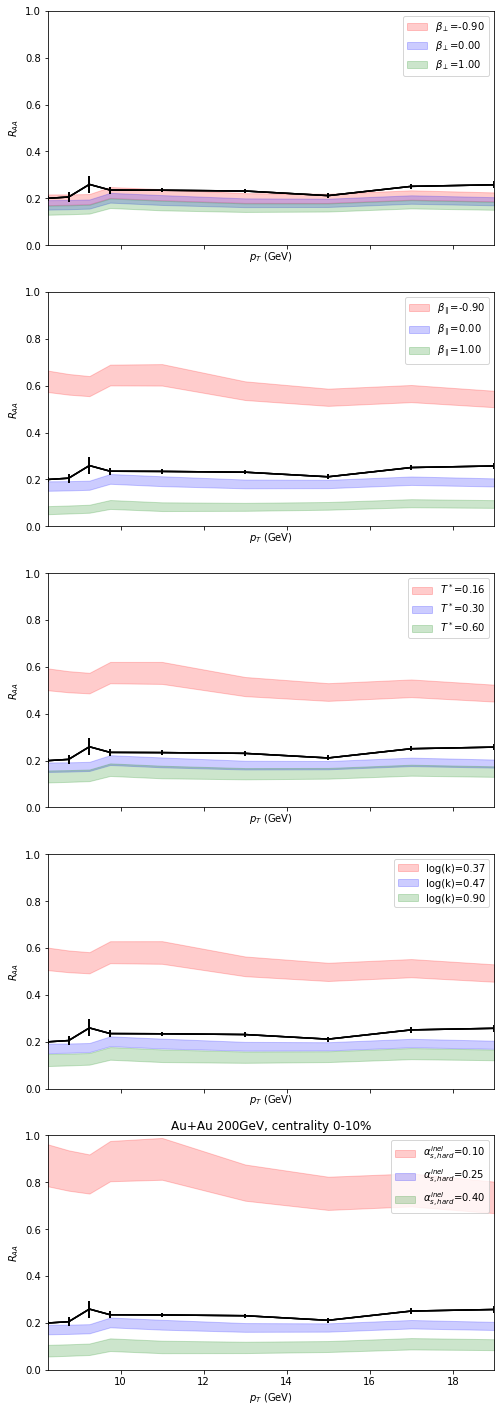

In [12]:
# val = [-8.981000000000000094e-01 2.343000000000000083e-01 4.631600000000000161e-01 8.432899999999999840e-01 3.805000000000000049e-01]
param_samp = np.array([[-0.9, 0, 1.], [-0.9, 0, 1.], [0.16, 0.3, 0.6], [0.37, 0.47, 0.9], [0.1, 0.25, 0.4]])
ParameterLabels = ['$\\beta_\perp$', '$\\beta_\parallel$', '$T^*$', 'log(k)', '$\\alpha^{inel}_{s, hard}$']
colors = ['r', 'b', 'g']

Y_validation = np.array([np.loadtxt(path+'/data/running_coupling/data_val_1obs')])
Y_validation_err = np.array([np.loadtxt(path+'/data/running_coupling/data_val_err_1obs')])

fig, axes = plt.subplots(5,1, figsize=(8,25), sharex=True)
labels = r"$R_{AA}$"

for i, color in enumerate(colors): 
    X_validation = np.array([param_samp.T[1]])

    for j, param_label in enumerate(ParameterLabels): 
        X_validation[0, j] = param_samp[j, i]
        A = np.array([predict_observables(it, diag_std=True) for it in X_validation])
        Y_predicted = A[:,0,:]
        Y_std = A[:,1,:]
        for k, (mean, std) in enumerate(zip(Y_predicted, Y_std)):
            label = param_label+'=%.2f' %param_samp[j, i]
            axes[j].fill_between(pT,mean[:Nc]-std[:Nc],mean[:Nc]+std[:Nc],color=color,alpha=.2, label=label)
        # label = 'Model calc.' if i == 0 else ''
        axes[j].errorbar(pT, Y_validation[0], Y_validation_err[0], color='black')
        axes[j].set_xlabel("$p_T$ (GeV)")
        axes[j].set_ylabel(labels)
        axes[j].legend()
        axes[j].set_ylim(0, 1.)
        axes[j].set_xlim(8.25, 19)

# titles = r"centrality 40-50%", r"centrality 40-50%"
titles = r"Au+Au 200GeV, centrality 0-10%"
# for ax, label, title in zip(axes, labels, titles):
# axes.set_xlabel("$p_T$ (GeV)")
# axes.set_ylabel(labels)
# axes.legend()
# axes.set_ylim(0, 0.5)
plt.title(titles)
# plt.tight_layout(True)
plt.savefig(path+"/plots/running_coupling/Emulator_validation_dps40")

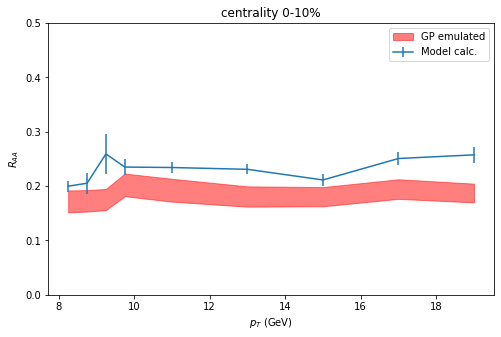

In [13]:
# Emulator validation
np.random.seed(9)
# X_validation = design_min + np.random.rand(2, Xdim)*design_ptp
# X_validation = np.array([design[0]])
# X_validation = np.array([design[0]])

# Next, get the emulator prediction and uncertainty
X_validation = np.array([[0, 0, 0.3, 0.47, 0.25]])
A = np.array([predict_observables(it, diag_std=True) for it in X_validation])
Y_predicted = A[:,0,:]
Y_std = A[:,1,:]
# print(Y_predicted.shape)


# Model calculation at these two points
# Y_validation = np.array([np.concatenate(ToyModel(param)) for param in X_validation])
# print(Y_validation.shape)
# Y_validation = np.array([simulation[0]])
Y_validation = np.array([np.loadtxt(path+'/data/running_coupling/data_val_1obs')])
Y_validation_err = np.array([np.loadtxt(path+'/data/running_coupling/data_val_err_1obs')])
# Y_validation_err = np.array([simulation_err[0]])

# plot the prediction + uncertainty band with the true model caluclation
fig, axes = plt.subplots(1,1, figsize=(8,5), sharex=True)
for i, (mean, std) in enumerate(zip(Y_predicted, Y_std)):
    label = 'GP emulated' if i==0 else''
    axes.fill_between(pT,mean[:Nc]-std[:Nc],mean[:Nc]+std[:Nc],color='r',alpha=.5, label=label)
    # axes[1].fill_between(pT,mean[Nc:]-std[Nc:],mean[Nc:]+std[Nc:],color='r',alpha=.5, label=label)
for i, ym, ym_err in zip(range(len(Y_validation)), Y_validation, Y_validation_err):
    label = 'Model calc.' if i==0 else''
    axes.errorbar(pT, ym[:Nc], yerr=ym_err[:Nc], label=label)
    # axes[1].errorbar(pT, ym[Nc:], yerr=ym_err[Nc:], label=label)



# Add labels
# labels = r"$R_{AA}$", r"$R_{AA}$", r"$"
labels = r"$R_{AA}$"
# titles = r"centrality 40-50%", r"centrality 40-50%"
titles = r"centrality 0-10%"
# for ax, label, title in zip(axes, labels, titles):
axes.set_xlabel("$p_T$ (GeV)")
axes.set_ylabel(labels)
axes.legend()
axes.set_ylim(0, 0.5)
axes.set_title(titles)
# plt.tight_layout(True)
plt.savefig(path+"/plots/running_coupling/Emulator_validation_test")

# 'b.', 

In [14]:
param_samp = np.array([[-0.9, 0., 1.], [-0.9, 0., 1.], [0.16, 0.3, 0.6], [0.37, 0.47, 0.9], [0.1, 0.25, 0.4]])
ParameterLabels = ['$\\beta_\perp$', '$\\beta_\parallel$', '$T^*$', 'ln(k)', '$\\alpha^{inel}_{s, hard}$']

In [15]:
def log_prior(model_parameters):
    """Evaluvate the prior at model prameter values. 
    If all parameters are inside bounds function will return 0 otherwise -inf"""
    X = np.array(model_parameters).reshape(1,-1)
    lower = np.all(X >= design_min)
    upper = np.all(X <= design_max)
    if (lower and upper):
        lp=0
    # lp = np.log(st.beta.pdf(X,5,1,dsgn_min_ut.reshape(1,-1),(dsgn_max_ut-dsgn_min_ut).reshape(1,-1))).sum()
    else:
        lp = -np.inf
    return lp

def mvn_loglike(y, cov):
    """
    Evaluate the multivariate-normal log-likelihood for difference vector `y`
    and covariance matrix `cov`:

        log_p = -1/2*[(y^T).(C^-1).y + log(det(C))] + const.

    The likelihood is NOT NORMALIZED, since this does not affect MCMC.  The
    normalization const = -n/2*log(2*pi), where n is the dimensionality.

    Arguments `y` and `cov` MUST be np.arrays with dtype == float64 and shapes
    (n) and (n, n), respectively.  These requirements are NOT CHECKED.

    The calculation follows algorithm 2.1 in Rasmussen and Williams (Gaussian
    Processes for Machine Learning).

    """
    # Compute the Cholesky decomposition of the covariance.
    # Use bare LAPACK function to avoid scipy.linalg wrapper overhead.
    L, info = lapack.dpotrf(cov, clean=False)

    if info < 0:
        raise ValueError(
            'lapack dpotrf error: '
            'the {}-th argument had an illegal value'.format(-info)
        )
    elif info < 0:
        raise np.linalg.LinAlgError(
            'lapack dpotrf error: '
            'the leading minor of order {} is not positive definite'
            .format(info)
        )

    # Solve for alpha = cov^-1.y using the Cholesky decomp.
    alpha, info = lapack.dpotrs(L, y)

    if info != 0:
        raise ValueError(
            'lapack dpotrs error: '
            'the {}-th argument had an illegal value'.format(-info)
         )

    if np.all(L.diagonal()>0):
        return -.5*np.dot(y, alpha) - np.log(L.diagonal()).sum()
    else:
        return -.5*np.dot(y, alpha) - np.log(np.abs(L.diagonal())).sum()
        print(L.diagonal())
        raise ValueError(
            'L has negative values on diagonal {}'.format(L.diagonal())
        )

def log_posterior(model_parameters):
    # model_parameters = np.array([model_parameters[0], model_parameters[1], model_parameters[1], model_parameters[2], 2, model_parameters[3]])
    mn, var = predict_observables(model_parameters)
    delta_y = mn - y_exp
    delta_y = delta_y.flatten()   
    total_var = var + y_exp_variance
    return log_prior(model_parameters) + mvn_loglike(delta_y,total_var)


# Closure Test

In [16]:
# validate with true values
# y_exp = np.loadtxt(path+'/data/true_RAA')
# y_exp_err = np.loadtxt(path+'/data/true_RAA_err')
# y_exp_variance = np.diag(y_exp_err**2)
y_exp = np.loadtxt(path+'/data/running_coupling/data_val_1obs')
y_exp_err = np.loadtxt(path+'/data/running_coupling/data_val_err_1obs')
y_exp_variance = np.diag(y_exp_err**2)

# print(y_err.shape)
# y_exp = simulation[7]
# y_err = np.loadtxt(path+'/data/RAA_data_err')
# y_exp_variance = np.diag(y_err**2)

## Reduce parameter dim to 4

In [17]:
test_max = np.array([1., 1., 0.6, 0.9, 0.4])
test_min = np.array([-0.9, -0.9, 0.16, 0.37, 0.1])
test_ptp = test_max - test_min

test_dim = 5

In [18]:
nwalkers = 10*test_dim  # number of MCMC walkers
nburn = 2000 # "burn-in" period to let chains stabilize
nsteps = 5000  # number of MCMC steps to take
# filename = data_path(name+".h5")


#backend = emcee.backends.HDFBackend(filename)
starting_guesses = test_min + (test_max - test_min) * np.random.rand(nwalkers, test_dim)

#print(starting_guesses)
print("MCMC sampling using emcee (affine-invariant ensamble sampler) with {0} walkers".format(nwalkers))
with Pool() as pool:
    sampler = emcee.EnsembleSampler(nwalkers, test_dim, log_posterior)
    print('burn in sampling started')    
    pos = sampler.run_mcmc(starting_guesses, nburn, progress=True, store=True)
    print("Mean acceptance fraction: {0:.3f} (in total {1} steps)".format(
                        np.mean(sampler.acceptance_fraction), nwalkers*nburn))
    print('Burn in completed.')
    print("Now running the samples")
    sampler.run_mcmc(initial_state=None, nsteps=nsteps, progress=True, tune=False)  
    print("Mean acceptance fraction: {0:.3f} (in total {1} steps)".format(
                        np.mean(sampler.acceptance_fraction), nwalkers*nsteps))
        
    # discard burn-in points and flatten the walkers; the shape of samples is (nwalkers*nsteps, Xdim)
    #samples = backend.get_chain(flat=True, discard=nburn)
    samples = sampler.get_chain(flat=True, discard=nburn)

# n_samples = len(samples)
# samples = np.concatenate((np.array([samples.T[0]]), np.array([samples.T[0]]), np.array([samples.T[1:3]]), np.array([[2 for _ in range(n_samples)]]), np.array([samples.T[3]])), axis=-1)
# print(samples.shape)

np.savetxt(path+'/data/running_coupling/MCMC_test_samples', samples)

MCMC sampling using emcee (affine-invariant ensamble sampler) with 50 walkers
burn in sampling started


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 2000/2000 [00:24<00:00, 80.30it/s]


Mean acceptance fraction: 0.347 (in total 100000 steps)
Burn in completed.
Now running the samples


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5000/5000 [01:01<00:00, 81.46it/s]


Mean acceptance fraction: 0.348 (in total 250000 steps)


In [19]:
USE_MAP = True
if USE_MAP:
    bounds=[(a,b) for (a,b) in zip(test_min,test_max)]
    parameters0 = optimize.differential_evolution(lambda x: -log_posterior(x), 
                                    bounds=bounds,
                                    tol=1e-9,
                                    ).x
else:
    parameters0 = [np.percentile(it,50) for it in samples.T]

In [20]:
true_values = np.array([0., 0., 0.3, 0.47, 0.25])
# true_values = design[7]

In [21]:
ParameterLabels = ['$\\beta_\perp$', '$\\beta_\parallel$', '$T^*$', 'log(k)', '$\\alpha^{inel}_{s, hard}$']
ranges = np.array([[-0.9, 1], [-0.9, 1], [0.16, 0.6], [0.37, 0.9], [0.1, 0.4]])

In [22]:
print(samples.shape)

(250000, 5)


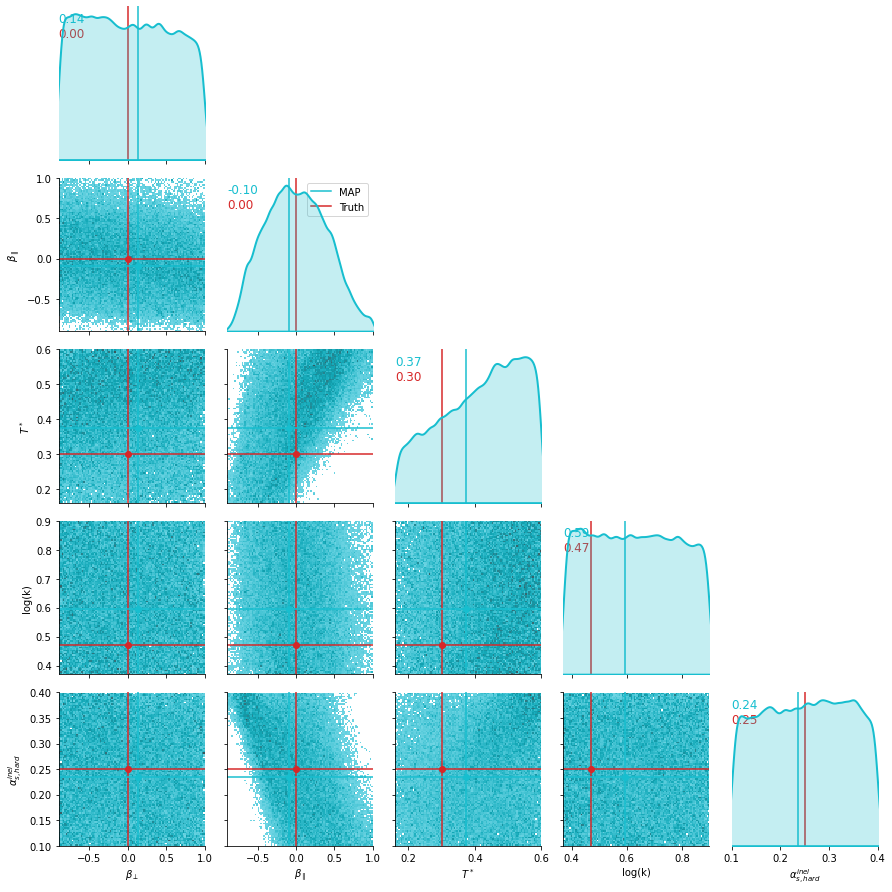

In [23]:
samples_df = pd.DataFrame(samples, columns=ParameterLabels)
g = sns.PairGrid(samples_df.iloc[:,:], corner=True, diag_sharey=False)
g.map_lower(sns.histplot, bins=100, color=sns.color_palette()[9])
g.map_diag(sns.kdeplot, linewidth=2, shade=True, color=sns.color_palette()[-1])
for n in range(test_dim):
    ax=g.axes[n][n]
    ax.axvline(x=parameters0[n], ls='-', c=sns.color_palette()[9], label='MAP')
    ax.axvline(x=true_values[n], ls='-', c=sns.color_palette()[3], label='Truth')
    ax.text(0,0.9,s= f'{parameters0[n]:.2f}', transform=ax.transAxes, color=sns.color_palette()[9], fontsize=12)
    ax.text(0,0.8,s= f'{true_values[n]:.2f}', transform=ax.transAxes, color=sns.color_palette()[3], fontsize=12)
g.axes[1,1].legend(loc='upper right', fontsize=10)
for i in range(test_dim):
    for j in range(i+1):
        g.axes[i,j].set_xlim(*ranges[j])
        if i==j:
            g.axes[i,j].set_ylim(*ranges[i])
            
        else:
            g.axes[i,j].set_ylim(ymax=0)
            g.axes[i,j].axvline(x=parameters0[j], ls='-', c=sns.color_palette()[9])
            g.axes[i,j].axvline(x=true_values[j], ls='-', c=sns.color_palette()[3])
            g.axes[i,j].axhline(y=parameters0[i], ls='-', c=sns.color_palette()[9])
            g.axes[i,j].axhline(y=true_values[i], ls='-', c=sns.color_palette()[3])
            g.axes[i,j].scatter(parameters0[j], parameters0[i], color=sns.color_palette()[9])
            g.axes[i,j].scatter(true_values[j], true_values[i], color=sns.color_palette()[3])
plt.tight_layout()
plt.savefig(path+'/plots/running_coupling/Posterior_of_true_parameters_pca1_lower1-5_param5_dps40')

In [24]:
Nsamples = 100
Nthin = samples_df.size//Nsamples
# prior parameter samples
prior_params = (ranges[:,1]-ranges[:,0])*np.random.rand(Nsamples,test_dim) + ranges[:,0]
# posterior parameter samples 
posterior_params =  samples_df.iloc[::Nthin,:].values
# prior_params = np.concatenate((np.array([prior_params.T[0]]).T, np.array([prior_params.T[1]]).T, prior_params.T[1:3].T, np.array([[2 for _ in range(Nsamples)]]).T, np.array([prior_params.T[3]]).T), axis=1)
# posterior_params = np.concatenate((np.array([posterior_params.T[0]]).T, np.array([posterior_params.T[1]]).T, posterior_params.T[1:3].T, np.array([[2 for _ in range(len(posterior_params))]]).T, np.array([posterior_params.T[3]]).T), axis=1)

prior_obs = []
posterior_obs = []

for p in prior_params: 
    A = np.array([predict_observables(p, diag_std=True)])
    Y_predicted = A[:,0,:]
    # prior_obs = np.array([np.concatenate(Y_predicted)])
    prior_obs.append(list(Y_predicted[0]))

for p in posterior_params: 
    A = np.array([predict_observables(p, diag_std=True)])
    Y_predicted = A[:,0,:]
    posterior_obs.append(list(Y_predicted[0]))
    
prior_obs = np.array(prior_obs)
posterior_obs = np.array(posterior_obs)

In [25]:
Nsamples = 100
Nthin = samples_df.size//Nsamples
# prior parameter samples
prior_params = (ranges[:,1]-ranges[:,0])*np.random.rand(Nsamples,test_dim) + ranges[:,0]
# posterior parameter samples 
posterior_params =  samples_df.iloc[::Nthin,:].values


prior_params = np.concatenate((np.array([prior_params.T[0]]).T, np.array([prior_params.T[1]]).T, prior_params.T[1:3].T, np.array([[2 for _ in range(Nsamples)]]).T, np.array([prior_params.T[3]]).T), axis=1)
posterior_params = np.concatenate((np.array([posterior_params.T[0]]).T, np.array([posterior_params.T[1]]).T, posterior_params.T[1:3].T, np.array([[2 for _ in range(len(posterior_params))]]).T, np.array([posterior_params.T[3]]).T), axis=1)

print(prior_params.shape)
print(posterior_params.shape)


(100, 6)
(20, 6)


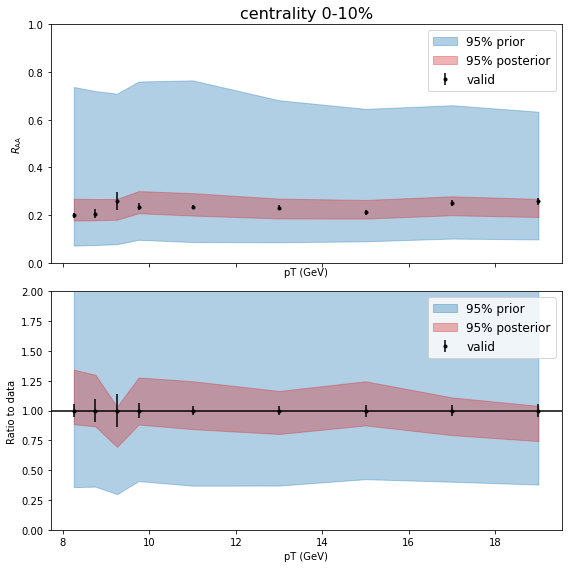

In [26]:
fig, axes = plt.subplots(2,1, figsize=(8,8), sharex=True)
CLbins = [95]
for isample, ilabel, color in zip([prior_obs, posterior_obs], 
                               ['prior','posterior'], 
                               [sns.color_palette()[0], sns.color_palette()[3]]):
    for CL, opacity in zip(CLbins, [.35, .3, .25, .2]):
        label = '{:d}% {}'.format(CL, ilabel)
        lower, upper = np.percentile(isample, [50-CL/2., 50+CL/2.], axis=0)
        axes[0].fill_between(pT, lower[:Nc], upper[:Nc], color=color, alpha=opacity, label=label)
        # axes[0,1].fill_between(pT, lower[Nc:], upper[Nc:], color=color, alpha=opacity, label=label)
        axes[1].fill_between(pT, (lower/y_exp)[:Nc], (upper/y_exp)[:Nc], color=color, alpha=opacity, label=label)
        # axes[1,1].fill_between(pT, (lower/y_exp)[Nc:], (upper/y_exp)[Nc:], color=color, alpha=opacity, label=label)

"""
for ax,y,yerr,name in zip(axes, 
                    [y_exp[:Nc], y_exp_err[:Nc]], [y_exp[:Nc], y_exp_err[:Nc]], 
                    [r"$R_{\rm AA}$", r"$R_{\rm AA}$"]):
"""
axes[0].errorbar(pT, y_exp[:Nc], yerr=y_exp_err[:Nc], fmt='k.', label='valid')
axes[0].set_ylabel(r"$R_{\rm AA}$")
axes[0].set_xlabel("pT (GeV)")
"""
for ax,y,yerr,name in zip(axes[1], 
                    [y_exp[:Nc], y_exp[Nc:]],[y_exp_err[:Nc], y_exp_err[Nc:]],
                    ["Ratio to data"]*2):
"""
axes[1].errorbar(pT, y_exp[:Nc]/y_exp[:Nc], yerr=y_exp_err[:Nc]/y_exp[:Nc], fmt='k.', label='valid')
axes[1].axhline(y=1, ls='-', color='k')
axes[1].set_ylabel("Ratio to data")
axes[1].set_xlabel("pT (GeV)")
# axes[0,0].semilogy()
# axes[0,1].semilogy()
axes[0].set_ylim(0,1)
# axes[0,1].set_ylim(0,1.8)

axes[1].set_ylim(0,2)
# axes[1, 0].set_ylim(0,5)
axes[0].set_title('centrality 0-10%', fontsize=16)
# axes[0, 1].set_title('centrality 40-50%', fontsize=16)
axes[0].legend(prop={'size': 12})
axes[1].legend(prop={'size': 12})
# axes[0, 1].legend(prop={'size': 12})
# plt.legend(loc='upper center', bbox_to_anchor=(0, -0.1), fancybox=True, shadow=True, ncol=3)
plt.tight_layout()
plt.savefig(path+"/plots/running_coupling/Posterior_validation_pca1_lower1-5_param5_dps40")

# Data analysis

In [ ]:
y_exp = np.loadtxt(path+'/data/running_coupling/data_RAA')
y_exp_err = np.loadtxt(path+'/data/running_coupling/data_RAA_err')
y_exp_variance = np.diag(y_exp_err**2)

In [ ]:
nwalkers = 10*Xdim  # number of MCMC walkers
nburn = 2000 # "burn-in" period to let chains stabilize
nsteps = 5000  # number of MCMC steps to take
# filename = data_path(name+".h5")


#backend = emcee.backends.HDFBackend(filename)
starting_guesses = design_min + (design_max - design_min) * np.random.rand(nwalkers, Xdim)
#print(starting_guesses)
print("MCMC sampling using emcee (affine-invariant ensamble sampler) with {0} walkers".format(nwalkers))
with Pool() as pool:
    sampler = emcee.EnsembleSampler(nwalkers, Xdim, log_posterior)
    print('burn in sampling started')    
    pos = sampler.run_mcmc(starting_guesses, nburn, progress=True, store=True)
    print("Mean acceptance fraction: {0:.3f} (in total {1} steps)".format(
                        np.mean(sampler.acceptance_fraction), nwalkers*nburn))
    print('Burn in completed.')
    print("Now running the samples")
    sampler.run_mcmc(initial_state=None, nsteps=nsteps, progress=True, tune=False)  
    print("Mean acceptance fraction: {0:.3f} (in total {1} steps)".format(
                        np.mean(sampler.acceptance_fraction), nwalkers*nsteps))
        
    # discard burn-in points and flatten the walkers; the shape of samples is (nwalkers*nsteps, Xdim)
    #samples = backend.get_chain(flat=True, discard=nburn)
    samples = sampler.get_chain(flat=True, discard=nburn)

np.savetxt(path+'/data/running_coupling/MCMC_samples', samples)

In [ ]:
USE_MAP = True
if USE_MAP:
    bounds=[(a,b) for (a,b) in zip(design_min,design_max)]
    parameters0 = optimize.differential_evolution(lambda x: -log_posterior(x), 
                                    bounds=bounds,
                                    tol=1e-9,
                                    ).x
else:
    parameters0 = [np.percentile(it,50) for it in samples.T]

In [ ]:
samples_df = pd.DataFrame(samples, columns=ParameterLabels)
plt.rcParams["axes.labelsize"] = 16
g = sns.PairGrid(samples_df.iloc[:,:], corner=True, diag_sharey=False)
g.map_lower(sns.histplot, bins=100, color=sns.color_palette()[0])
g.map_diag(sns.kdeplot, linewidth=2, shade=True, color=sns.color_palette()[0])
for n in range(Xdim):
    ax=g.axes[n][n]
    ax.axvline(x=parameters0[n], ls='-', c=sns.color_palette()[0], label='MAP')
    # ax.axvline(x=true_values[n], ls='-', c=sns.color_palette()[3], label='Truth')
    ax.text(0.1,0.7,s= f'{parameters0[n]:.2f}', transform=ax.transAxes, color=sns.color_palette()[0], fontsize=16)
    # ax.text(0,0.8,s= f'{true_values[n]:.2f}', transform=ax.transAxes, color=sns.color_palette()[3], fontsize=12)
g.axes[1,1].legend(loc='best', fontsize=11)
for i in range(Xdim):
    for j in range(i+1):
        g.axes[i,j].set_xlim(*ranges[j])
        if i==j:
            g.axes[i,j].set_ylim(*ranges[i])
            
        else:
            # g.axes[i,j].set_ylim(0, 2)
            g.axes[i,j].axvline(x=parameters0[j], ls='-', c=sns.color_palette()[0])
            # g.axes[i,j].axvline(x=true_values[j], ls='-', c=sns.color_palette()[3])
            g.axes[i,j].axhline(y=parameters0[i], ls='-', c=sns.color_palette()[0])
            # g.axes[i,j].axhline(y=true_values[i], ls='-', c=sns.color_palette()[3])
            g.axes[i,j].scatter(parameters0[j], parameters0[i], color=sns.color_palette()[3])
            # g.axes[i,j].scatter(true_values[j], true_values[i], color=sns.color_palette()[3])
plt.tight_layout()
plt.savefig(path+'/plots/running_coupling/Posterior_of_parameters_test')

In [ ]:
Nsamples = 100
Nthin = samples_df.size//Nsamples
# prior parameter samples
prior_params = (ranges[:,1]-ranges[:,0])*np.random.rand(Nsamples,Xdim) + ranges[:,0]
# posterior parameter samples 
posterior_params =  samples_df.iloc[::Nthin,:].values
prior_obs = []
posterior_obs = []

for p in prior_params: 
    A = np.array([predict_observables(p, diag_std=True)])
    Y_predicted = A[:,0,:]
    # prior_obs = np.array([np.concatenate(Y_predicted)])
    prior_obs.append(list(Y_predicted[0]))

for p in posterior_params: 
    A = np.array([predict_observables(p, diag_std=True)])
    Y_predicted = A[:,0,:]
    posterior_obs.append(list(Y_predicted[0]))
    
prior_obs = np.array(prior_obs)
posterior_obs = np.array(posterior_obs)

In [ ]:
fig, axes = plt.subplots(2,1, figsize=(8,8), sharex=True)
CLbins = [95]
for isample, ilabel, color in zip([prior_obs, posterior_obs], 
                               ['prior','posterior'], 
                               [sns.color_palette()[0], sns.color_palette()[3]]):
    for CL, opacity in zip(CLbins, [.35, .3, .25, .2]):
        label = '{:d}% {}'.format(CL, ilabel)
        lower, upper = np.percentile(isample, [50-CL/2., 50+CL/2.], axis=0)
        axes[0].fill_between(pT, lower[:Nc], upper[:Nc], color=color, alpha=opacity, label=label)
        # axes[0,1].fill_between(pT, lower[Nc:], upper[Nc:], color=color, alpha=opacity, label=label)
        axes[1].fill_between(pT, (lower/y_exp)[:Nc], (upper/y_exp)[:Nc], color=color, alpha=opacity, label=label)
        # axes[1,1].fill_between(pT, (lower/y_exp)[Nc:], (upper/y_exp)[Nc:], color=color, alpha=opacity, label=label)

"""
for ax,y,yerr,name in zip(axes, 
                    [y_exp[:Nc], y_exp_err[:Nc]], [y_exp[:Nc], y_exp_err[:Nc]], 
                    [r"$R_{\rm AA}$", r"$R_{\rm AA}$"]):
"""
axes[0].errorbar(pT, y_exp[:Nc], yerr=y_exp_err[:Nc], fmt='k.', label='PHENIX 2013')
axes[0].set_ylabel(r"$R_{\rm AA}$")
axes[0].set_xlabel("pT (GeV)")
"""
for ax,y,yerr,name in zip(axes[1], 
                    [y_exp[:Nc], y_exp[Nc:]],[y_exp_err[:Nc], y_exp_err[Nc:]],
                    ["Ratio to data"]*2):
"""
axes[1].errorbar(pT, y_exp[:Nc]/y_exp[:Nc], yerr=y_exp_err[:Nc]/y_exp[:Nc], fmt='k.', label='PHENIX 2013')
axes[1].axhline(y=1, ls='-', color='k')
axes[1].set_ylabel("Ratio to data")
axes[1].set_xlabel("pT (GeV)")
# axes[0,0].semilogy()
# axes[0,1].semilogy()
axes[0].set_ylim(0,1)
# axes[0,1].set_ylim(0,1.8)

axes[1].set_ylim(0,2)
# axes[1, 0].set_ylim(0,5)
axes[0].set_title('centrality 0-10%', fontsize=16)
# axes[0, 1].set_title('centrality 40-50%', fontsize=16)
axes[0].legend(prop={'size': 12})
axes[1].legend(prop={'size': 12})
# axes[0, 1].legend(prop={'size': 12})
# plt.legend(loc='upper center', bbox_to_anchor=(0, -0.1), fancybox=True, shadow=True, ncol=3)
plt.tight_layout()
plt.savefig(path+"/plots/running_coupling/Posterior_validation_test")

In [ ]:
fig, axes = plt.subplots(2,2, figsize=(15,12), sharex=True)
CLbins = [60, 95]
for isample, ilabel, color in zip([prior_obs, posterior_obs], 
                               ['prior','posterior'], 
                               [sns.color_palette()[0], sns.color_palette()[3]]):
    for CL, opacity in zip(CLbins, [.35, .3, .25, .2]):
        label = '{:d}% {}'.format(CL, ilabel)
        lower, upper = np.percentile(isample, [50-CL/2., 50+CL/2.], axis=0)
        axes[0,0].fill_between(pT, lower[:Nc], upper[:Nc], color=color, alpha=opacity, label=label)
        axes[0,1].fill_between(pT, lower[Nc:], upper[Nc:], color=color, alpha=opacity, label=label)
        axes[1,0].fill_between(pT, (lower/y_exp)[:Nc], (upper/y_exp)[:Nc], color=color, alpha=opacity, label=label)
        axes[1,1].fill_between(pT, (lower/y_exp)[Nc:], (upper/y_exp)[Nc:], color=color, alpha=opacity, label=label)
    
for ax,y,yerr,name in zip(axes[0], 
                    [y_exp[:Nc], y_exp[Nc:]], [y_exp_err[:Nc], y_exp_err[Nc:]], 
                    [r"$R_{\rm AA}$", r"$R_{\rm AA}$"]):
    ax.errorbar(pT, y, yerr=yerr, fmt='k.', label='$\\alpha_s=0.3$')
    ax.set_ylabel(name)
    ax.set_xlabel("pT (GeV)")
    
for ax,y,yerr,name in zip(axes[1], 
                    [y_exp[:Nc], y_exp[Nc:]],[y_exp_err[:Nc], y_exp_err[Nc:]],
                    ["Ratio to data"]*2):
    ax.errorbar(pT, y/y, yerr=yerr/y, fmt='k.', label='$\\alpha_s=0.3$')
    ax.set_ylabel(name)
    ax.set_xlabel("pT (GeV)")
# axes[0,0].semilogy()
# axes[0,1].semilogy()
axes[0,0].set_ylim(0,2)
axes[0,1].set_ylim(0,2)
axes[1,0].set_ylim(0,2)
axes[1,1].set_ylim(0,2)
axes[0, 0].set_title('centrality 0-10%', fontsize=16)
axes[0, 1].set_title('centrality 40-50%', fontsize=16)
axes[0, 0].legend()
axes[0, 1].legend()
# plt.legend(loc='upper center', bbox_to_anchor=(0, -0.1), fancybox=True, shadow=True, ncol=3)
plt.tight_layout()
plt.savefig(path+"/plots/running_coupling/Posterior_true_validation_test")